# References:
* https://github.com/rlcode/reinforcement-learning/tree/master/2-cartpole/4-actor-critic
* https://www.kaggle.com/thimac/ppo-lunar-lander-reinforcement-learning

In [1]:
!apt-get install -y python-opengl
!apt-get install -y ffmpeg

from IPython.display import clear_output
clear_output()

from xvfbwrapper import Xvfb

vdisplay = Xvfb(width=1280, height=740)
vdisplay.start()
print('Done')

Done


In [2]:
import gym
import pylab
import time
import itertools
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import Math, HTML

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model

import tensorflow as tf
# This is important! It speeds up the training by a lot
tf.compat.v1.disable_eager_execution()

In [3]:
GAMMA = 0.99
EPISODES = 1000
LR_ACTOR = 0.001
LR_CRITIC = 0.005

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [4]:
def create_animation(frames):
    rc('animation', html='jshtml')
    fig = plt.figure()
    plt.axis("off")
    im = plt.imshow(frames[0], animated=True)

    def updatefig(i):
        im.set_array(frames[i])
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=len(frames), interval=20, blit=True)
    display(HTML(ani.to_html5_video()))    
    plt.close()    
    
    return ani

In [5]:
def plot_reward_history(rewards, lr_actor, lr_critic, save_to_file):
    plt.figure(0)
    plt.cla()
    ax = sns.lineplot(data=np.array(rewards))
    plt.show()
    
    if save_to_file:
        plt.figure(0).savefig(str(lr_actor) + '-' + str(lr_critic) + '.png')

In [6]:
class A2CAgent:
    def __init__(self, state_size, action_size, gamma=GAMMA, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, load_model_from_file=False):
        self.load_model_from_file = load_model_from_file

        self.gamma = gamma
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic

        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        if self.load_model_from_file:
            self.actor = load_model('cartpole_actor.h5')
            self.critic = load_model('cartpole_critic.h5')
        else:
            self.actor = self.build_actor()
            self.critic = self.build_critic()

    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='he_uniform'))
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.lr_actor))
        # actor.summary()
        return actor

    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='he_uniform'))
        critic.compile(loss="mse", optimizer=Adam(lr=self.lr_critic))
        # critic.summary()
        return critic

    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1)[0]
        action_idx = np.random.choice(self.action_size, 1, p=policy)[0]
        return action_idx

    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))
        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward - value + self.gamma * (next_value)
            target[0][0] = reward + self.gamma * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

    def save_models(self):
        self.actor.save("cartpole_actor.h5")
        self.critic.save("cartpole_critic.h5")

In [7]:
def record_episode(agent):
    frames = []
    done = False

    state = env.reset()
    state = np.array(state)[np.newaxis, :]

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        state = np.reshape(next_state, [1, state_size])
        frames.append(env.render(mode="rgb_array"))

    ani = create_animation(frames)

In [8]:
def train_agent(nr_of_episodes=EPISODES, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, render=False):
    scores = []
    agent = A2CAgent(state_size, action_size, lr_actor=lr_actor, lr_critic=lr_critic)

    try:
        for episode_idx in range(nr_of_episodes):
            done = False
            score = 0
            state = env.reset()
            state = np.reshape(state, [1, state_size])

            state_mem = []
            action_mem = []
            reward_mem = []
            next_state_mem = []
            done_mem = []

            while not done:
                action = agent.get_action(state)
                next_state, reward, done, _ = env.step(action)
                next_state = np.reshape(next_state, [1, state_size])

                # if an action make the episode end, then gives penalty of -100
                reward = reward if not done or score == 499 else -100

                state_mem.append(state)
                action_mem.append(action)
                reward_mem.append(reward)
                next_state_mem.append(next_state)
                done_mem.append(done)

                score += reward
                state = next_state

                if done:
                    for i in range(len(state_mem)):
                        agent.train_model(state_mem[i], action_mem[i], reward_mem[i], next_state_mem[i], done_mem[i])

                        # reverse the state, next state and action
                        state_reversed = np.array(state_mem[i]) * -1
                        next_state_reversed = np.array(next_state_mem[i]) * -1
                        action_reversed = (action_mem[i] + 1) % 2
                        agent.train_model(state_reversed, action_reversed, reward_mem[i], next_state_reversed, done_mem[i])

                        
                    # every episode, plot the play time
                    score = score if score == 500.0 else score + 100
                    scores.append(score)

                    if (episode_idx % 50) == 49:
                        print(episode_idx+1, 'Episode score:', score)
                        # plot_reward_history(scores)

                    if np.mean(scores[-min(10, len(scores)):]) > 490:
                        agent.save_models()
                        return

            # save the model when ever the last 2 runs are close to optimum
            if len(scores) > 2 and np.mean(scores[-2]) > 490:
                agent.save_models()
    finally:
        plot_reward_history(scores, lr_actor=lr_actor, lr_critic=lr_critic, save_to_file=False)

In [9]:
agent = A2CAgent(state_size, action_size)
record_episode(agent)

LR Actor: 0.001 , LR Critic: 0.005
50 Episode score: 49.0
100 Episode score: 500.0
150 Episode score: 55.0
200 Episode score: 39.0
250 Episode score: 500.0
300 Episode score: 111.0
350 Episode score: 257.0
400 Episode score: 11.0


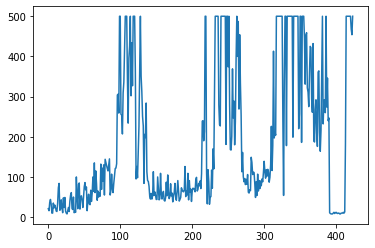

In [10]:
lrs_actor = [0.001]
lrs_critic = [0.005]

for r in itertools.product(lrs_actor, lrs_critic):
    lr_actor = r[0]
    lr_critic = r[1]
    print("LR Actor:", lr_actor, ", LR Critic:", lr_critic)
    train_agent(nr_of_episodes=1500, lr_actor=lr_actor, lr_critic=lr_critic)

In [11]:
agent = A2CAgent(state_size, action_size, load_model_from_file=True)
record_episode(agent)